Autores:

- Ronaldo Lopes Inocêncio Júnior
- Filipe Loyola Lopes
- Victor Castro Nacif de Faria

# 0.0 - Imports

In [ ]:
!pip install igraph

     |████████████████████████████████| 3.1 MB 17.1 MB/s 


In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import random
import json
import functools
import os

## 0.1 - Funções de Auxílio

In [ ]:
def graph_network_description(graph):
    amount_vertices = graph.vcount()
    amount_edges = graph.ecount()
    diameter = graph.diameter()
    
    return {
        'amount_vertices': amount_vertices,
        'amount_edges': amount_edges,
        'diameter': diameter
    }

def define_grupo(grupo):
    if grupo == 'GRUPO_0':
        return 0
    elif grupo == 'GRUPO_1':
        return 1
    elif grupo == 'GRUPO_2':
        return 2
    else:
        return 3

def fast_greedy_modularity(graph, n_clusters=None):
    dendogram = graph.community_fastgreedy()

    if n_clusters:
        clusters = dendogram.as_clustering(n=n_clusters)
    else:
        clusters = dendogram.as_clustering()

    Q = graph.modularity(clusters)

    return round(Q, 5), len(clusters)

def modularity_with_cluster(graph, clusters):
    return round(graph.modularity(clusters), 5)

def exame_esta_no_intervalo_de_similaridade(valor_do_exame_i, valor_do_exame_j, nome_do_exame):
    valor_min = valor_do_exame_i - std_dict[nome_do_exame]
    valor_max = valor_do_exame_i + std_dict[nome_do_exame]

    if valor_do_exame_j >= valor_min and valor_do_exame_j < valor_max:
        return True
    else:
        return False

def cria_estrutura_de_pontuacao():
    score_exames = {}

    for i in range(df2.shape[0]):
        score_exames[f"{i}"] = {}
        for j in range(i+1, df2.shape[0]):
            score = 0
            for exame in exames:
                exame_values = df2[exame].values

                valor_do_exame_i = exame_values[i]
                valor_do_exame_j = exame_values[j]

            if exame_esta_no_intervalo_de_similaridade(valor_do_exame_i, valor_do_exame_j, exame):
                score = score + 1
                score_exames[f"{i}"][f"{j}"] = score

    with open('score.json', 'w') as fp:
        json.dump(score_exames, fp)

def load_estrutura_de_pontuacao():
    json_file = open('score.json', "r")

    return json.loads(json_file.read())

def define_conexoes_entre_vertices(score_exames, quantidade_de_exames_similares):
    edge_list = []
    for i in range(df2.shape[0]):
        pontuacao_dos_vertices = score_exames[f"{i}"]

        for vertice in pontuacao_dos_vertices.keys():
            if pontuacao_dos_vertices[vertice] >= quantidade_de_exames_similares:
                edge_list.append((i,int(vertice)))

    return edge_list

# 1.0 - Leitura e Modelagem dos Dados

In [ ]:
df_raw = pd.read_csv('sirio_aprendizado_v3.csv', sep='|')

In [ ]:
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df1 = df_raw.copy()

In [ ]:
df1.head(2)

,ID_PACIENTE,GRUPO,Idade,Sexo,ALT (TGP),AST (TGO),Basófilos,Basófilos (%),CHCM,Creatinina,...,Neutrófilos (%),Plaquetas,Potássio,Proteína C-Reativa,RDW,Sódio,Uréia,VCM,Volume plaquetário médio,SEXO
0,00017961865C4F766FDBB3CD8FE0BFB0,GRUPO_0,54,M,26.0,24.0,40.0,0.6,34.5,1.02,...,78.0,176000.0,4.0,0.11,13.1,138.0,35.0,86.0,9.8,1
1,000F0BC139D2846DB86AA32B8F05B215,GRUPO_0,41,M,NaN,NaN,20.0,0.4,33.2,1.04,...,37.4,279000.0,4.3,NaN,14.0,142.0,33.0,83.2,10.0,1


In [ ]:
df1.isnull().sum()

ID_PACIENTE                    0
GRUPO                          0
Idade                          0
Sexo                           0
ALT (TGP)                   1569
AST (TGO)                   1590
Basófilos                    387
Basófilos (%)                387
CHCM                         389
Creatinina                   865
Eosinófilos                  387
Eosinófilos (%)              387
Eritrócitos                  387
HCM                          389
Hematócrito                  386
Hemoglobina                  384
Leucócitos                   387
Linfócitos                   387
Linfócitos (%)               387
Monócitos                    387
Monócitos (%)                387
Neutrófilos                  387
Neutrófilos (%)              389
Plaquetas                    380
Potássio                    1441
Proteína C-Reativa          1266
RDW                          387
Sódio                       1501
Uréia                       1073
VCM                          387
Volume pla

In [ ]:
percent_missing = df1.isnull().sum() * 100 / len(df1)
missing_value_df = pd.DataFrame({'column_name': df1.columns,
                                 'percent_missing': percent_missing})

In [ ]:
missing_value_df

,column_name,percent_missing
ID_PACIENTE,ID_PACIENTE,0.000000
GRUPO,GRUPO,0.000000
Idade,Idade,0.000000
Sexo,Sexo,0.000000
ALT (TGP),ALT (TGP),36.319444
AST (TGO),AST (TGO),36.805556
Basófilos,Basófilos,8.958333
Basófilos (%),Basófilos (%),8.958333
CHCM,CHCM,9.004630
Creatinina,Creatinina,20.023148


## 1.1 - Normalizar dados

Como a idade é um atributo importante, irei deslocar a coluna "Idade" para ficar próxima das colunas dos exames, para que ela também seja normalizada.

In [ ]:
cols = list(df1.columns.values)
print(cols)

['ID_PACIENTE', 'GRUPO', 'Idade', 'Sexo', 'ALT (TGP)', 'AST (TGO)', 'Basófilos', 'Basófilos (%)', 'CHCM', 'Creatinina', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos', 'HCM', 'Hematócrito', 'Hemoglobina', 'Leucócitos', 'Linfócitos', 'Linfócitos (%)', 'Monócitos', 'Monócitos (%)', 'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas', 'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'Uréia', 'VCM', 'Volume plaquetário médio', 'SEXO']


In [ ]:
df1 = df1[['ID_PACIENTE', 'GRUPO', 'Sexo','Idade','ALT (TGP)', 'AST (TGO)', 'Basófilos', 'Basófilos (%)', 'CHCM', 'Creatinina', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos', 'HCM', 'Hematócrito', 'Hemoglobina', 'Leucócitos', 'Linfócitos', 'Linfócitos (%)', 'Monócitos', 'Monócitos (%)', 'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas', 'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'Uréia', 'VCM', 'Volume plaquetário médio', 'SEXO']]

In [ ]:
df_aux = df1[df1.columns[3:]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df1.drop(columns=df1.columns[3:], inplace=True)

df1 = pd.concat([df1, df_aux], axis=1)

df1.head(3)

,ID_PACIENTE,GRUPO,Sexo,Idade,ALT (TGP),AST (TGO),Basófilos,Basófilos (%),CHCM,Creatinina,Eosinófilos,Eosinófilos (%),Eritrócitos,HCM,Hematócrito,Hemoglobina,Leucócitos,Linfócitos,Linfócitos (%),Monócitos,Monócitos (%),Neutrófilos,Neutrófilos (%),Plaquetas,Potássio,Proteína C-Reativa,RDW,Sódio,Uréia,VCM,Volume plaquetário médio,SEXO
0,00017961865C4F766FDBB3CD8FE0BFB0,GRUPO_0,M,0.590909,0.051345,0.068376,0.097561,0.127660,0.714286,0.087420,0.020134,0.043902,0.497065,0.548246,0.464455,0.574803,0.045227,0.007432,0.152412,0.076316,0.102908,0.177523,0.799353,0.248895,0.400,0.001965,0.134969,0.533333,0.143617,0.51448,0.372549,1.0
1,000F0BC139D2846DB86AA32B8F05B215,GRUPO_0,M,0.443182,NaN,NaN,0.048780,0.085106,0.598214,0.089552,0.053691,0.165854,0.508806,0.456140,0.445498,0.511811,0.032229,0.018538,0.529605,0.102632,0.190157,0.061203,0.361381,0.400589,0.475,NaN,0.190184,0.666667,0.132979,0.46678,0.411765,1.0
2,0028785949D91BD93442838FC898E229,GRUPO_0,F,0.329545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Dicionário que é responsável por definir a faixa de similaridade entre os vértices, neste exemplo, estamos baseando o intervalo utilizando como referência o desvio padrão da coluna

In [ ]:
df1_sem_preencher_valores_nulos = df1.copy()

In [ ]:
def altera_range(df1_sem_preencher_valores_nulos, denominador):

    std_dict = {
      'ALT (TGP)': round(df1_sem_preencher_valores_nulos['ALT (TGP)'].std()/denominador,3),
      'Proteína C-Reativa': round(df1_sem_preencher_valores_nulos['Proteína C-Reativa'].std()/denominador,3),
      'AST (TGO)': round(df1_sem_preencher_valores_nulos['AST (TGO)'].std()/denominador,3),
      'Idade': round(df1_sem_preencher_valores_nulos['Idade'].std()/denominador,3),
      'Creatinina': round(df1_sem_preencher_valores_nulos['Creatinina'].std()/denominador,3),
      'Uréia': round(df1_sem_preencher_valores_nulos['Uréia'].std()/denominador,3),
      'RDW': round(df1_sem_preencher_valores_nulos['RDW'].std()/denominador,3),
      'Potássio': round(df1_sem_preencher_valores_nulos['Potássio'].std()/denominador,3),
      'Eritrócitos': round(df1_sem_preencher_valores_nulos['Eritrócitos'].std()/denominador,3),
      'Neutrófilos': round(df1_sem_preencher_valores_nulos['Neutrófilos'].std()/denominador,3)
    }

    return std_dict

## 1.2 - Preencher valores nulos

In [ ]:
for column in df1.columns[4:]:
    df1[column] = df1[column].apply(lambda x: -1 if math.isnan(x) else x)

df1.head(3)

,ID_PACIENTE,GRUPO,Sexo,Idade,ALT (TGP),AST (TGO),Basófilos,Basófilos (%),CHCM,Creatinina,Eosinófilos,Eosinófilos (%),Eritrócitos,HCM,Hematócrito,Hemoglobina,Leucócitos,Linfócitos,Linfócitos (%),Monócitos,Monócitos (%),Neutrófilos,Neutrófilos (%),Plaquetas,Potássio,Proteína C-Reativa,RDW,Sódio,Uréia,VCM,Volume plaquetário médio,SEXO
0,00017961865C4F766FDBB3CD8FE0BFB0,GRUPO_0,M,0.590909,0.051345,0.068376,0.097561,0.127660,0.714286,0.087420,0.020134,0.043902,0.497065,0.548246,0.464455,0.574803,0.045227,0.007432,0.152412,0.076316,0.102908,0.177523,0.799353,0.248895,0.400,0.001965,0.134969,0.533333,0.143617,0.51448,0.372549,1.0
1,000F0BC139D2846DB86AA32B8F05B215,GRUPO_0,M,0.443182,-1.000000,-1.000000,0.048780,0.085106,0.598214,0.089552,0.053691,0.165854,0.508806,0.456140,0.445498,0.511811,0.032229,0.018538,0.529605,0.102632,0.190157,0.061203,0.361381,0.400589,0.475,-1.000000,0.190184,0.666667,0.132979,0.46678,0.411765,1.0
2,0028785949D91BD93442838FC898E229,GRUPO_0,F,0.329545,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.0


## 1.3 - Alterar ID do paciente para número

In [ ]:
df1['ID_PACIENTE'] = list(range(df1.shape[0]))

df1.head(3)

,ID_PACIENTE,GRUPO,Sexo,Idade,ALT (TGP),AST (TGO),Basófilos,Basófilos (%),CHCM,Creatinina,Eosinófilos,Eosinófilos (%),Eritrócitos,HCM,Hematócrito,Hemoglobina,Leucócitos,Linfócitos,Linfócitos (%),Monócitos,Monócitos (%),Neutrófilos,Neutrófilos (%),Plaquetas,Potássio,Proteína C-Reativa,RDW,Sódio,Uréia,VCM,Volume plaquetário médio,SEXO
0,0,GRUPO_0,M,0.590909,0.051345,0.068376,0.097561,0.127660,0.714286,0.087420,0.020134,0.043902,0.497065,0.548246,0.464455,0.574803,0.045227,0.007432,0.152412,0.076316,0.102908,0.177523,0.799353,0.248895,0.400,0.001965,0.134969,0.533333,0.143617,0.51448,0.372549,1.0
1,1,GRUPO_0,M,0.443182,-1.000000,-1.000000,0.048780,0.085106,0.598214,0.089552,0.053691,0.165854,0.508806,0.456140,0.445498,0.511811,0.032229,0.018538,0.529605,0.102632,0.190157,0.061203,0.361381,0.400589,0.475,-1.000000,0.190184,0.666667,0.132979,0.46678,0.411765,1.0
2,2,GRUPO_0,F,0.329545,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.0


# 2.0 - Identificação e Criação da Rede

In [ ]:
df2 = df1.copy()

In [ ]:
exames = ['ALT (TGP)', 'Proteína C-Reativa', 'AST (TGO)', 'Idade', 'Creatinina', 'Uréia', 'RDW', 'Potássio', 'Eritrócitos', 'Neutrófilos']

Simulação da estrutura de dados e as conexões que serão feitas


In [ ]:
teste = {
  "0": {
    "1": 3,
    "2": 8,
    "3": 6
  },
  "1": {
    "2": 9,
    "3": 7,
    "4": 6
  }
}

edg = []
for i in range(2):
    pontuacao_dos_vertices = teste[f"{i}"]
    for vertice in pontuacao_dos_vertices.keys():
        if pontuacao_dos_vertices[vertice] > 6:
            edg.append((i,int(vertice)))
edg

[(0, 2), (1, 2), (1, 3)]

Define o range para criação da rede.

In [ ]:
std_dict = altera_range(df1_sem_preencher_valores_nulos, 4)

Cria toda estrutura de pontuacao para saber quantos exames em comum cada vértice possui com os demais, baseando-se no range definido acima.

In [ ]:
cria_estrutura_de_pontuacao()

Carrega a estrutura salva em um arquivo JSON realizada no passo anterior .

In [ ]:
estrutura = load_estrutura_de_pontuacao()

Cria a rede baseada na estrutura de pontuacao, definindo o número de exames em comum desejado.

In [ ]:
edge_list = define_conexoes_entre_vertices(estrutura, 6)

graph = ig.Graph()

graph.add_vertices(df2.shape[0])
graph.add_edges(edge_list)

Descrição básica da rede

In [ ]:
graph_network_description(graph)

{'amount_edges': 317658, 'amount_vertices': 4320, 'diameter': 8}

In [ ]:
cont = 0
for grau in graph.degree():
    if grau == 0:
        cont = cont+1

print('Quantidade de vértices com grau 0:', cont)

Quantidade de vértices com grau 0: 126


In [ ]:
print('Grau médio da rede: ', round(ig.mean(graph.degree()), 3))

Grau médio da rede:  147.064


# 3.0 - Amostragem da Rede

In [ ]:
df3 = df2.copy()

## 3.1 - Identificar grupo do vértice

Identifica qual grupo pertence o vértice e define uma marcação nele

In [ ]:
df3_aux = df3[['ID_PACIENTE','GRUPO']]
df3_aux['CLUSTER'] = df3['GRUPO'].apply(lambda x: define_grupo(x))

group_clusters = df3_aux['CLUSTER'].values
graph.vs['grupo'] = group_clusters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 3.2 - Amostragem

Iremos amostrar redes com n = 1000, e gerar pelo menos umas 100 redes com a  quantidade n de vértices, porém, de forma aleatória.

Esse snap irá construir uma DataFrame com amostras de 100 redes, com suas respectivas propriedades

In [ ]:
def amostrar_rede(sample_graph, must_sample=False):
    network_list = []
    degree_list = []
    vertices_count_list = []
    cc_list = []
    apl_list = []
    degree_variance_list = []
    vertices_zero_degree_list = []

    for n in range(100):
    if must_sample:
        random_vertices = random.sample(range(1, df2.shape[0]), network_len)
        sample_graph = graph.subgraph(random_vertices)

    # Calcula quantidade de vértices com grau 0 antes de analisar seu componente gigante
    vertices_zero_degree = functools.reduce(lambda acc, grau: acc + 1 if grau == 0 else acc + 0, sample_graph.degree(), 0)
  
    # Pega o componente gigante dessa amostra
    sample_graph = sample_graph.clusters().giant()

    # Número de vértices 
    vertices_count_list.append(sample_graph.vcount())

    # Calcula o grau médio da rede
    degree_distribution = sample_graph.degree()
    average_degree = round(ig.mean(degree_distribution), 3)
    
    # Calcula a variância do grau da rede
    degree_variance = round(np.var(degree_distribution), 3)

    # Calcula o coeficiente de agrupamento da rede
    cc = ig.GraphBase.transitivity_local_undirected(sample_graph)
    cc = round(np.mean([coeficiente for coeficiente in cc if not math.isnan(coeficiente)]), 3)

    # Calcula o caminho médio entre os vértices
    apl = round(ig.GraphBase.average_path_length(sample_graph),3)

    network_list.append(sample_graph)
    degree_list.append(average_degree)
    cc_list.append(cc)
    apl_list.append(apl)
    degree_variance_list.append(degree_variance)
    vertices_zero_degree_list.append(vertices_zero_degree)

    return pd.DataFrame({
      'network': network_list, 
      'vertices_count': vertices_count_list,
      'average_degree': degree_list, 
      'cc': cc_list, 
      'apl': apl_list, 
      'degree_variance': degree_variance_list,
      'vertices_zero_degree': vertices_zero_degree_list
    })

In [ ]:
network_len = 1000

df_sample = amostrar_rede(graph, True)

A tabela abaixo mostra um pouco da descrição do grau médio e da quantidade de vértice, perceba que o seu desvio padrão não é muito alto. Logo, nossas redes amostradas tendem a possuir um grau médio parecido. Assim como o número de vértices amostrados que também não tende a oscilar muito.

In [ ]:
df_sample[['average_degree', 'vertices_count', 'cc', 'degree_variance', 'vertices_zero_degree']].describe()

,average_degree,vertices_count,cc,degree_variance,vertices_zero_degree
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,37.832090,917.660000,0.327050,2816.060360,78.170000
std,3.114928,8.858278,0.012039,480.983179,8.177396
min,30.223000,889.000000,0.302000,1696.908000,63.000000
25%,35.697250,911.000000,0.318750,2454.495500,71.000000
50%,38.137500,918.000000,0.329000,2813.768000,78.000000
75%,40.405250,925.000000,0.335000,3135.955250,85.000000
max,44.135000,934.000000,0.358000,4018.110000,97.000000


# 4.0 - Modularidade

## 4.1 - Modularidade de Referência (4 Grupos) e FastGreedy

Modularidade de referência da rede original (TOTAL) com os grupos separados manualmente [0,1,2,3].

In [ ]:
clusters = graph.vs['grupo']
modularity_with_cluster(graph, clusters)

0.00328

Modularidade obtida pelo algoritmo fast_greedy

In [ ]:
fast_greedy_modularity(graph.as_undirected())

(0.34827, 134)

In [ ]:
fast_greedy_modularity(graph.as_undirected())[0]

0.34827

Calcula modularidade de referência e fastgreedy para cada instância da rede

In [ ]:
df_sample['modularity_fastgreedy'] = df_sample['network'].apply(lambda x: fast_greedy_modularity(x.as_undirected())[0])
df_sample['clusters_modularity_fg'] = df_sample['network'].apply(lambda x: fast_greedy_modularity(x.as_undirected())[1])

df_sample['reference_modularity'] = df_sample['network'].apply(lambda x: modularity_with_cluster(x.as_undirected(), x.vs['grupo']))

In [ ]:
df_sample.head(5)

,network,vertices_count,average_degree,cc,apl,degree_variance,vertices_zero_degree,modularity_fastgreedy,clusters_modularity_fg,reference_modularity
0,IGRAPH U--- 904 16922 --\n+ attr: grupo (v)\n+...,904,37.438,0.325,3.363,2795.306,91,0.31800,4,0.00309
1,IGRAPH U--- 918 18771 --\n+ attr: grupo (v)\n+...,918,40.895,0.334,3.368,3237.407,80,0.30823,3,0.00154
2,IGRAPH U--- 909 17998 --\n+ attr: grupo (v)\n+...,909,39.600,0.332,3.379,2997.450,85,0.34090,4,0.00116
3,IGRAPH U--- 902 17658 --\n+ attr: grupo (v)\n+...,902,39.153,0.329,3.384,3023.562,92,0.31315,5,0.00034
4,IGRAPH U--- 920 17757 --\n+ attr: grupo (v)\n+...,920,38.602,0.320,3.369,2931.544,78,0.32458,4,0.00285


In [ ]:
df_sample[['modularity_fastgreedy', 'clusters_modularity_fg', 'reference_modularity']].describe()

,modularity_fastgreedy,clusters_modularity_fg,reference_modularity
count,100.000000,100.000000,100.000000
mean,0.332371,4.000000,0.002824
std,0.025283,1.271283,0.001621
min,0.269600,2.000000,-0.000570
25%,0.312248,3.000000,0.001800
50%,0.333505,4.000000,0.002755
75%,0.345962,5.000000,0.003683
max,0.403720,9.000000,0.007740


# 5.0 - Comparação com modelos da literatura

In [ ]:
def model_comparison(df_sample, df_er, df_ba, df_ws, denominador):

    average_degree_list = []
    cc_list = []
    apl_list = []
    degree_variance_list = []
    vertices_zero_degree_list = []

    average_degree_list.append(np.mean(df_sample['average_degree'].values))
    cc_list.append(np.mean(df_sample['cc'].values))
    degree_variance_list.append(np.mean(df_sample['degree_variance'].values))
    apl_list.append(np.mean(df_sample['apl'].values))
    vertices_zero_degree_list.append(np.mean(df_sample['vertices_zero_degree'].values))

    average_degree_list.append(np.mean(df_er['average_degree'].values))
    cc_list.append(np.mean(df_er['cc'].values))
    degree_variance_list.append(np.mean(df_er['degree_variance'].values))
    apl_list.append(np.mean(df_er['apl'].values))
    vertices_zero_degree_list.append(np.mean(df_er['vertices_zero_degree'].values))

    average_degree_list.append(np.mean(df_ba['average_degree'].values))
    cc_list.append(np.mean(df_ba['cc'].values))
    degree_variance_list.append(np.mean(df_ba['degree_variance'].values))
    apl_list.append(np.mean(df_ba['apl'].values))
    vertices_zero_degree_list.append(np.mean(df_ba['vertices_zero_degree'].values))

    average_degree_list.append(np.mean(df_ws['average_degree'].values))
    cc_list.append(np.mean(df_ws['cc'].values))
    degree_variance_list.append(np.mean(df_ws['degree_variance'].values))
    apl_list.append(np.mean(df_ws['apl'].values))
    vertices_zero_degree_list.append(np.mean(df_ws['vertices_zero_degree'].values))

    df_comparison = pd.DataFrame({'network': ['Exame Network', 'Erdos-Rényi', 'Barabasi-Albert','Watts Strogats'],
                                'average_degree': average_degree_list,
                                'CC': cc_list,
                                'APL': apl_list,
                                'degree_variance': degree_variance_list,
                                'vertices_zero_degree': vertices_zero_degree_list
                                })

    df_comparison.to_csv(f'model_comparison_denominador_{denominador}.csv', sep=',', index=False)

Executar esse snippet se quiser realizar a comparação das redes variando o denominador de de 1 até 10.

In [ ]:
for i in range(1,11):
    std_dict = altera_range(df1_sem_preencher_valores_nulos, i)

    cria_estrutura_de_pontuacao()
    estrutura = load_estrutura_de_pontuacao()

    edge_list = define_conexoes_entre_vertices(estrutura, quantidade_de_exames_similares=6)

    graph = ig.Graph()

    graph.add_vertices(df2.shape[0])
    graph.add_edges(edge_list)

    network_len = 1000
    df_sample = amostrar_rede(graph, True)

    degree_mean = round(np.mean(df_sample['average_degree'].values))

    graph_er = ig.Graph.Erdos_Renyi(n=network_len, p=(degree_mean/network_len))
    df_er = amostrar_rede(graph_er)

    graph_ba = ig.Graph.Barabasi(n=network_len, m=math.ceil(degree_mean/2))
    df_ba = amostrar_rede(graph_ba)

    graph_ws = ig.Graph.Watts_Strogatz(dim=1, size=network_len, nei=math.ceil(degree_mean/2), p=(degree_mean/network_len))
    df_ws = amostrar_rede(graph_ws)

    model_comparison(df_sample, df_er, df_ba, df_ws, i)

## 5.1 - Análise dos resultados

In [24]:
path = 'network_comparison_2'
csv_files = sorted(os.listdir(path))

df_comparison = pd.DataFrame()
for csv_file in csv_files:
    print(csv_file)
    df_csv = pd.read_csv(f'{path}/{csv_file}')

    df_comparison = pd.concat([df_comparison, df_csv])

# Variação do grau médio pelo range
average_degree_exame_network = df_comparison[df_comparison['network'] == 'Exame Network']['average_degree'].values
average_degree_ER = df_comparison[df_comparison['network'] == 'Erdos-Rényi']['average_degree'].values
average_degree_BA = df_comparison[df_comparison['network'] == 'Barabasi-Albert']['average_degree'].values
average_degree_WS = df_comparison[df_comparison['network'] == 'Watts Strogats']['average_degree'].values

# Variação do CC pelo range
CC_exame_network = df_comparison[df_comparison['network'] == 'Exame Network']['CC'].values
CC_ER = df_comparison[df_comparison['network'] == 'Erdos-Rényi']['CC'].values
CC_BA = df_comparison[df_comparison['network'] == 'Barabasi-Albert']['CC'].values
CC_WS = df_comparison[df_comparison['network'] == 'Watts Strogats']['CC'].values

# Variação do APL pelo range
APL_exame_network = df_comparison[df_comparison['network'] == 'Exame Network']['APL'].values
APL_ER = df_comparison[df_comparison['network'] == 'Erdos-Rényi']['APL'].values
APL_BA = df_comparison[df_comparison['network'] == 'Barabasi-Albert']['APL'].values
APL_WS = df_comparison[df_comparison['network'] == 'Watts Strogats']['APL'].values

# Variação do Variância do Grau pelo range
degree_variance_exame_network = df_comparison[df_comparison['network'] == 'Exame Network']['degree_variance'].values
degree_variance_ER = df_comparison[df_comparison['network'] == 'Erdos-Rényi']['degree_variance'].values
degree_variance_BA = df_comparison[df_comparison['network'] == 'Barabasi-Albert']['degree_variance'].values
degree_variance_WS = df_comparison[df_comparison['network'] == 'Watts Strogats']['degree_variance'].values

model_comparison_denominador_01.csv
model_comparison_denominador_02.csv
model_comparison_denominador_03.csv
model_comparison_denominador_04.csv
model_comparison_denominador_05.csv
model_comparison_denominador_06.csv
model_comparison_denominador_07.csv
model_comparison_denominador_08.csv
model_comparison_denominador_09.csv
model_comparison_denominador_10.csv


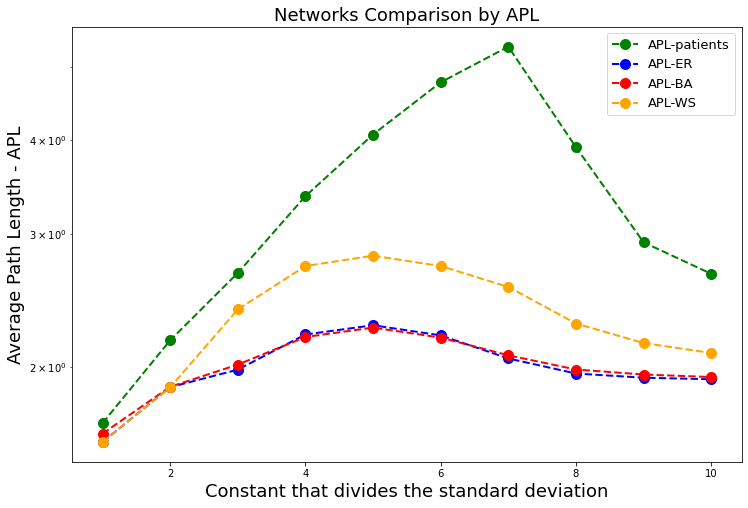

In [25]:
denominador_values = list(range(1,11))

plt.figure(figsize=(12,8))
plt.plot(denominador_values, APL_exame_network, color='green', linestyle='dashed', marker='o', markersize=10, label='APL-patients', linewidth=2)
plt.plot(denominador_values, APL_ER, color='blue', linestyle='dashed', marker='o', markersize=10, label='APL-ER', linewidth=2)
plt.plot(denominador_values, APL_BA, color='red', linestyle='dashed', marker='o', markersize=10, label='APL-BA', linewidth=2)
plt.plot(denominador_values, APL_WS, color='orange', linestyle='dashed', marker='o', markersize=10, label='APL-WS', linewidth=2)
plt.yscale('log')
plt.legend(loc='best', prop={"size":13})
plt.xlabel('Constant that divides the standard deviation',fontsize=18)
plt.ylabel('Average Path Length - APL', fontsize=18);
plt.title('Networks Comparison by APL', fontsize=18);   
plt.savefig('apl.png') 

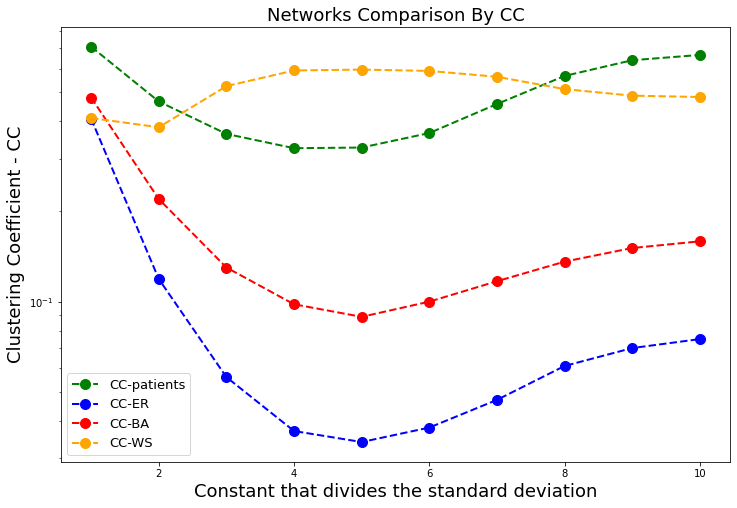

In [26]:
plt.figure(figsize=(12,8))
plt.plot(denominador_values, CC_exame_network, color='green', linestyle='dashed', marker='o', markersize=10, label='CC-patients', linewidth=2)
plt.plot(denominador_values, CC_ER, color='blue', linestyle='dashed', marker='o', markersize=10, label='CC-ER', linewidth=2)
plt.plot(denominador_values, CC_BA, color='red', linestyle='dashed', marker='o', markersize=10, label='CC-BA', linewidth=2)
plt.plot(denominador_values, CC_WS, color='orange', linestyle='dashed', marker='o', markersize=10, label='CC-WS', linewidth=2)
plt.yscale('log')
plt.legend(loc='best', prop={"size":13})
plt.xlabel('Constant that divides the standard deviation', fontsize=18)
plt.ylabel('Clustering Coefficient - CC', fontsize=18);
plt.title(f'Networks Comparison By CC', fontsize=18);
plt.savefig('CC.png') 

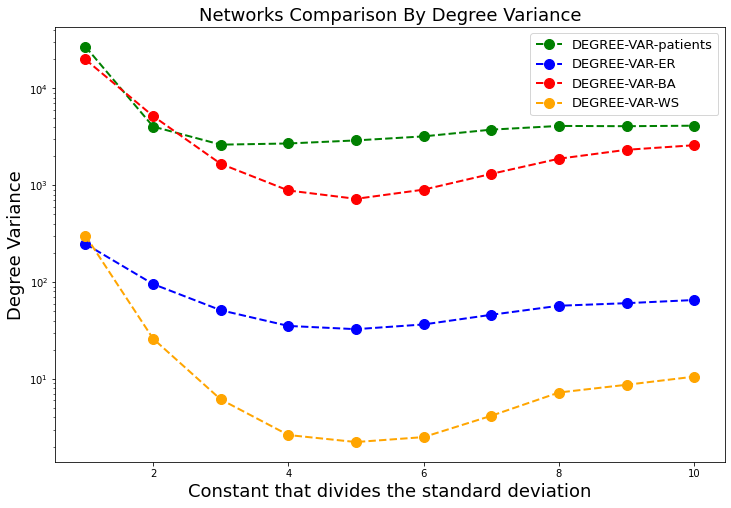

In [27]:
plt.figure(figsize=(12,8))
plt.plot(denominador_values, degree_variance_exame_network, color='green', linestyle='dashed', marker='o', markersize=10, label='DEGREE-VAR-patients', linewidth=2)
plt.plot(denominador_values, degree_variance_ER, color='blue', linestyle='dashed', marker='o', markersize=10, label='DEGREE-VAR-ER', linewidth=2)
plt.plot(denominador_values, degree_variance_BA, color='red', linestyle='dashed', marker='o', markersize=10, label='DEGREE-VAR-BA', linewidth=2)
plt.plot(denominador_values, degree_variance_WS, color='orange', linestyle='dashed', marker='o', markersize=10, label='DEGREE-VAR-WS', linewidth=2)
plt.yscale('log')
plt.legend(loc='best', prop={"size":13})
plt.xlabel('Constant that divides the standard deviation', fontsize=18)
plt.ylabel('Degree Variance', fontsize=18);
plt.title(f'Networks Comparison By Degree Variance', fontsize=18);
plt.savefig('degree_variance.png') 

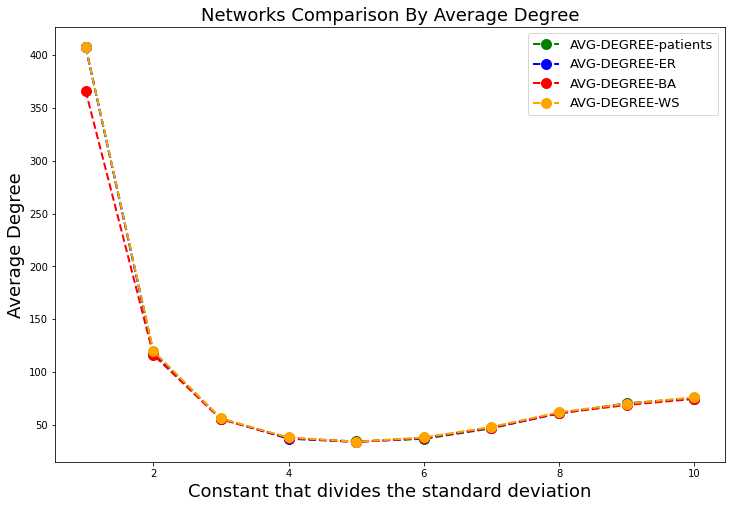

In [28]:
plt.figure(figsize=(12,8))
plt.plot(denominador_values, average_degree_exame_network, color='green', linestyle='dashed', marker='o', markersize=10, label='AVG-DEGREE-patients', linewidth=2)
plt.plot(denominador_values, average_degree_ER, color='blue', linestyle='dashed', marker='o', markersize=10, label='AVG-DEGREE-ER', linewidth=2)
plt.plot(denominador_values, average_degree_BA, color='red', linestyle='dashed', marker='o', markersize=10, label='AVG-DEGREE-BA', linewidth=2)
plt.plot(denominador_values, average_degree_WS, color='orange', linestyle='dashed', marker='o', markersize=10, label='AVG-DEGREE-WS', linewidth=2)
plt.legend(loc='best', prop={"size":13})
plt.xlabel('Constant that divides the standard deviation', fontsize=18)
plt.ylabel('Average Degree', fontsize=18);
plt.title(f'Networks Comparison By Average Degree', fontsize=18);
plt.savefig('average_degree.png') 